In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa

import cmath
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

In [2]:
H_c = qml.PauliZ(0) + qml.PauliZ(1) + qml.PauliZ(2)
H_m = qml.PauliX(0) + qml.PauliX(1) + qml.PauliX(2)

In [14]:
wires = [0, 1, 2]
num_layers = 2
dev = qml.device('default.qubit', wires=wires)

In [15]:
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_c)
    qaoa.mixer_layer(beta, H_m)

def circuit(gammas, betas):
    for w in wires:
        qml.Hadamard(w)

    qml.layer(qaoa_layer, num_layers, gammas, betas)

@qml.qnode(dev)
def cost_function(params):
    circuit(gammas=params[0], betas=params[1])
    return qml.expval(H_c)

In [18]:
params = np.array([[0.5]*num_layers, [0.5]*num_layers], requires_grad=True)
gammas = params[0]
betas = params[1]

print(qml.draw(circuit)(gammas,betas))

0: ──H─╭ApproxTimeEvolution(0.50)─╭ApproxTimeEvolution(0.50)─╭ApproxTimeEvolution(0.50)
1: ──H─├ApproxTimeEvolution(0.50)─├ApproxTimeEvolution(0.50)─├ApproxTimeEvolution(0.50)
2: ──H─╰ApproxTimeEvolution(0.50)─╰ApproxTimeEvolution(0.50)─╰ApproxTimeEvolution(0.50)

──╭ApproxTimeEvolution(0.50)─┤  
──├ApproxTimeEvolution(0.50)─┤  
──╰ApproxTimeEvolution(0.50)─┤  


(<Figure size 800x400 with 1 Axes>, <Axes: >)

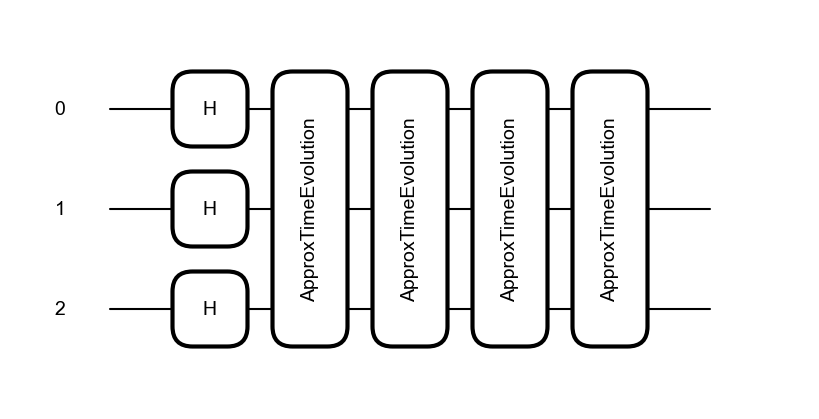

In [17]:
qml.draw_mpl(circuit)(gammas, betas)

In [10]:
#Optimization

opt = qml.GradientDescentOptimizer()
steps = 200
params = np.array([[0.5]*num_layers, [0.5]*num_layers], requires_grad=True)

for _ in range(steps):
    params = opt.step(cost_function, params)

In [14]:
@qml.qnode(dev)
def circuit_state(params):
    circuit(gammas=params[0], betas=params[1])
    return qml.state()

np.round(circuit_state(params), decimals=5)

tensor([ 0.-0.j,  0.-0.j,  0.-0.j, -0.+0.j, -0.-0.j, -0.-0.j,  0.-0.j,
        -1.+0.j], requires_grad=True)

In [16]:
def qaoa_layer_snapshot(gamma, beta):
    qaoa.cost_layer(gamma, H_c)
    qml.Snapshot()
    qaoa.mixer_layer(beta, H_m)
    qml.Snapshot()

def circuit_snapshot(gammas, betas):
    for w in wires:
        qml.Hadamard(w)

    qml.layer(qaoa_layer_snapshot, num_layers, gammas, betas)

@qml.qnode(dev)
def circuit_state_snapshot(params):
    circuit_snapshot(gammas=params[0], betas=params[1])
    return qml.state()

snaps = qml.snapshots(circuit_state_snapshot)(params)

In [20]:
amplitudes = np.zeros(2*num_layers)
phases = np.zeros(2*num_layers)

for i in range(2*num_layers):
    solution_coeff = snaps[i].reshape(2,2,2)[1,1,1]
    amplitudes[i] = np.real(solution_coeff * np.conj(solution_coeff))
    phases[i] = cmath.phase(solution_coeff)

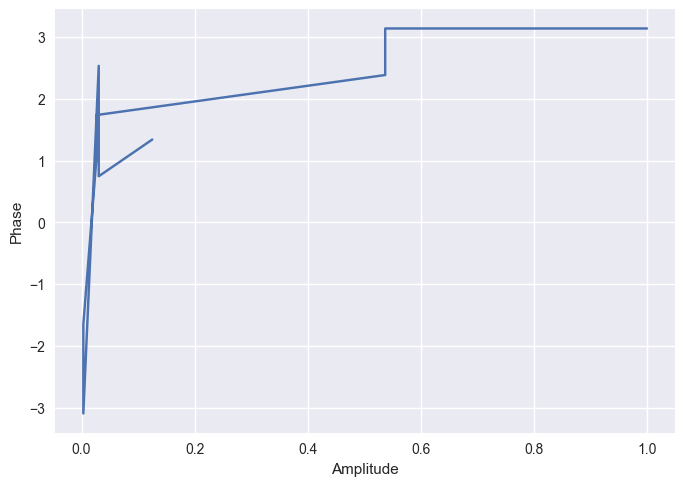

In [21]:
plt.plot(amplitudes, phases)
plt.ylabel('Phase')
plt.xlabel('Amplitude')
plt.show()